# 1. IMPORT DEPENDENCES



In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers, optimizers
import tensorflow as tf
from tensorflow.keras.applications import ResNet50,VGG16,ResNet101, VGG19, DenseNet201, EfficientNetB4, MobileNetV2
from tensorflow.keras.applications import resnet, vgg16 , vgg19, densenet, efficientnet, mobilenet_v2
from tensorflow.keras import Model

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import PIL
import os
import cv2

In [ ]:
import os

save_dir = '/content/models/'
os.makedirs(save_dir, exist_ok=True)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. GET THE DATA READY FOR TRAINING

In [ ]:
path = "/content/drive/MyDrive/Data/train"
for files in os.listdir(path):
    print(os.path.join(path,files))

/content/drive/MyDrive/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
/content/drive/MyDrive/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
/content/drive/MyDrive/Data/train/normal
/content/drive/MyDrive/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


Then we set the path for this data.

In [ ]:
train_path = "/content/drive/MyDrive/Data/train"
valid_path = "/content/drive/MyDrive/Data/valid"
test_path = "/content/drive/MyDrive/Data/test"

In [ ]:
image_paths = ['/content/drive/MyDrive/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa',
'/content/drive/MyDrive/Data/train/normal',
'/content/drive/MyDrive/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
'/content/drive/MyDrive/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib']

def load_images(image_paths=image_paths, n=36, target_size=(224, 224)):
    images = []
    for i in range(len(image_paths)):
        images_ = []
        for path in os.listdir(image_paths[i])[:int(n/4)]:
            img = cv2.imread(image_paths[i] + '/' + path)
            if img is not None:
                img = cv2.resize(img, target_size)
                images_.append(img)
        images.append(images_)
    sample = np.asarray(images)
    return sample

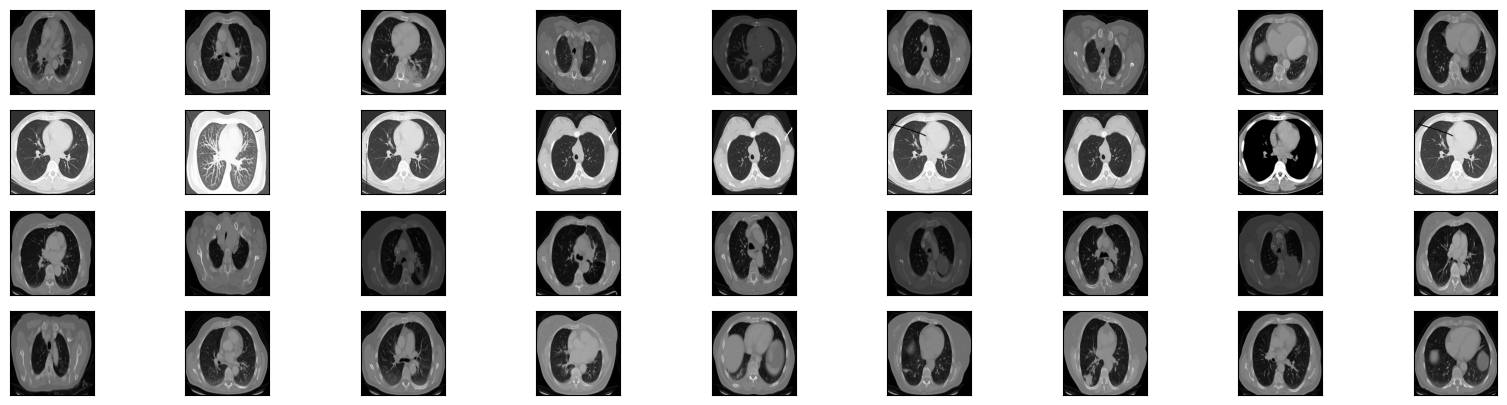

In [ ]:
sample = load_images()
fig = plt.figure(figsize=(20,5))
l = 1
shapes = []
for i in range(sample.shape[0]):
    for m in range(sample.shape[1]):
        ax = fig.add_subplot(4,9,m+l,xticks = [], yticks = [])
        ax.imshow(np.squeeze(sample[i,m]))
        shapes.append(sample[i,m].shape)
    l +=9

In [ ]:
np.array(shapes).mean(axis=0)

array([224., 224.,   3.])

# 3. IMAGE PREPROCESSING

* When using Gradient Descent, We should ensure that all Features have a similar scale, otherwise, it will take much longer to converge.

In [ ]:
image_shape = (305,430,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', rescale = 1.0/255.0)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


# 4. BUILDING THE MODEL ARCHITECTURE

In [ ]:
base_hidden_units = 8
weight_decay = 1e-3
model = Sequential([

    Conv2D(filters = 8 , kernel_size = 2, padding = 'same', activation = 'relu', input_shape = image_shape),
    MaxPooling2D(pool_size = 2),

    Conv2D(filters = 16 , kernel_size = 2, padding = 'same', activation = 'relu',
           kernel_regularizer = regularizers.l2(weight_decay)),
    MaxPooling2D(pool_size = 2),

    #Conv2D(filters = 64 , kernel_size = 2, padding = 'same', activation = 'relu',
     #     kernel_regularizer = regularizers.l2(weight_decay)),
    #MaxPooling2D(pool_size = 2),

    Dropout(0.4),
    Flatten(),
    Dense(300,activation='relu'),
    Dropout(0.5),
    Dense(4,activation='softmax')

])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 305, 430, 8)    │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 152, 215, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 152, 215, 16)   │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 76, 107, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 76, 107, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 130112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │    39,033,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,035,736 (148.91 MB)

 Trainable params: 39,035,736 (148.91 MB)

 Non-trainable params: 0 (0.00 B)

# 5. TRAIN THE MODEL

In [ ]:
checkpointer = ModelCheckpoint('/content/models/chestmodel.keras',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 15)
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-5)

model.compile(loss= 'categorical_crossentropy', optimizer= optimizer, metrics=['acc'])
history = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.3534 - loss: 1.3448
Epoch 1: val_loss improved from inf to 1.38655, saving model to /content/models/chestmodel.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - acc: 0.3528 - loss: 1.3440 - val_acc: 0.4167 - val_loss: 1.3866
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - acc: 0.4003 - loss: 1.2831
Epoch 2: val_loss improved from 1.38655 to 1.30877, saving model to /content/models/chestmodel.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 598ms/step - acc: 0.4027 - loss: 1.2815 - val_acc: 0.4306 - val_loss: 1.3088
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - acc: 0.4523 - loss: 1.2001
Epoch 3: val_loss improved from 1.30877 to 1.28203, saving model to /content/models/chestmodel.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 431ms/step - acc: 0.4539 - loss: 1.1989 - val_acc: 0.4444 - val_loss: 1.2820
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - acc: 0.4823 - loss: 1.1798
Epoch 4: val_loss improved from 1.28203 to 1.21960, sav

In [ ]:
#model.save('/content/models/chestmodel.hdf5')
result = model.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 131s 12s/step - acc: 0.5454 - loss: 1.3538


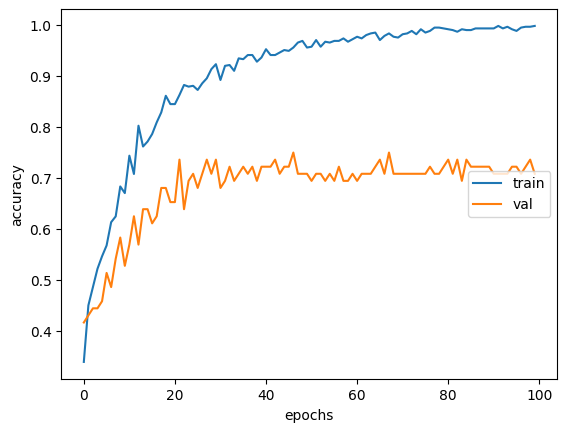

In [ ]:
plt.plot(history.history['acc'], label = 'train',)
plt.plot(history.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# 6. TRANSFER LEARNING

## RESNET50

In [ ]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=resnet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')
print(train_generator.class_indices)


valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=resnet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')
print(train_generator.class_indices)


test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=resnet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')
print(train_generator.class_indices)


Found 613 images belonging to 4 classes.
{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}
Found 72 images belonging to 4 classes.
{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}
Found 315 images belonging to 4 classes.
{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}


In [ ]:
res_model = ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in res_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False
# Check if all layers except conv5 layers are not trainable
#for i, layer in enumerate(res_model.layers):
#    print(i, layer.name, "-", layer.trainable)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = Sequential()
model.add(res_model)
model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,604,100 (90.04 MB)

 Trainable params: 14,988,292 (57.18 MB)

 Non-trainable params: 8,615,808 (32.87 MB)

In [ ]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
save_dir = '/content/models/'

In [ ]:
checkpointer = ModelCheckpoint(filepath=os.path.join(save_dir, 'chest_CT_SCAN-ResNet50.keras'),
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [ ]:
history_res = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.2541 - loss: 2.8582
Epoch 1: val_loss improved from inf to 1.81244, saving model to /content/models/chest_CT_SCAN-ResNet50.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - acc: 0.2548 - loss: 2.8481 - val_acc: 0.2778 - val_loss: 1.8124
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - acc: 0.3583 - loss: 2.1243
Epoch 2: val_loss improved from 1.81244 to 1.42416, saving model to /content/models/chest_CT_SCAN-ResNet50.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 602ms/step - acc: 0.3591 - loss: 2.1201 - val_acc: 0.2778 - val_loss: 1.4242
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - acc: 0.3884 - loss: 1.9487
Epoch 3: val_loss improved from 1.42416 to 1.17448, saving model to /content/models/chest_CT_SCAN-ResNet50.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 651ms/step - acc: 0.3893 - loss: 1.9462 - val_acc: 0.4583 - val_loss: 1.1745
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - acc: 0.4733 - loss: 1.6763
Epoch 4: val_loss i

In [ ]:
#model.save('/content/models/chest_CT_SCAN-ResNet50.hdf5')
result = model.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - acc: 0.7774 - loss: 0.6808


## DenseNet201

In [ ]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')
print(train_generator.class_indices)


valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')
print(train_generator.class_indices)


test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')
print(train_generator.class_indices)


Found 613 images belonging to 4 classes.
{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}
Found 72 images belonging to 4 classes.
{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}
Found 315 images belonging to 4 classes.
{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}


In [ ]:
dense_model = DenseNet201(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in dense_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False
# Check if all layers except conv5 layers are not trainable
#for i, layer in enumerate(dense_model.layers):
#    print(i, layer.name, "-", layer.trainable)


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = Sequential()
model.add(dense_model)
#model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
#model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 1920)           │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1920)           │         7,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         7,684 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,337,348 (69.95 MB)

 Trainable params: 6,990,084 (26.67 MB)

 Non-trainable params: 11,347,264 (43.29 MB)

In [ ]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
save_dir = '/content/models/'

In [ ]:
checkpointer = ModelCheckpoint(filepath=os.path.join(save_dir, 'chest_CT_SCAN-DenseNet201.keras'),
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [ ]:
history_dense = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 200,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - acc: 0.3568 - loss: 1.4118
Epoch 1: val_loss improved from inf to 1.23803, saving model to /content/models/chest_CT_SCAN-DenseNet201.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 341s 9s/step - acc: 0.3604 - loss: 1.4039 - val_acc: 0.3889 - val_loss: 1.2380
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - acc: 0.7111 - loss: 0.7808
Epoch 2: val_loss improved from 1.23803 to 1.14753, saving model to /content/models/chest_CT_SCAN-DenseNet201.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 829ms/step - acc: 0.7116 - loss: 0.7778 - val_acc: 0.4306 - val_loss: 1.1475
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - acc: 0.8319 - loss: 0.5686
Epoch 3: val_loss improved from 1.14753 to 1.06586, saving model to /content/models/chest_CT_SCAN-DenseNet201.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 822ms/step - acc: 0.8328 - loss: 0.5661 - val_acc: 0.4861 - val_loss: 1.0659
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - acc: 0.9059 - loss: 0.4109
Epoch 4: 

In [ ]:
#model.save('/content/models/chest_CT_SCAN-DenseNet201.hdf5')
result = model.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - acc: 0.8381 - loss: 0.4473


# Let's Tweak the HyperParameter Tuning

## ResNet50

In [ ]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32')#, preprocessing_function=resnet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32')#, preprocessing_function=resnet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32')#, preprocessing_function=resnet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [ ]:
res_model = ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in res_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False
# Check if all layers except conv5 layers are not trainable
#for i, layer in enumerate(res_model.layers):
#    print(i, layer.name, "-", layer.trainable)

In [ ]:
model = Sequential()
model.add(res_model)
model.add(Dropout(0.4))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,604,100 (90.04 MB)

 Trainable params: 14,988,292 (57.18 MB)

 Non-trainable params: 8,615,808 (32.87 MB)

In [ ]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-5)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
save_dir = '/content/'

In [ ]:
checkpointer = ModelCheckpoint(filepath=os.path.join(save_dir, 'chest_CT_SCAN-ResNet50.keras'),
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=20)

In [ ]:
history_res = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 200,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - acc: 0.2752 - loss: 2.1460
Epoch 1: val_loss improved from inf to 1.27218, saving model to /content/chest_CT_SCAN-ResNet50.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - acc: 0.2768 - loss: 2.1374 - val_acc: 0.3194 - val_loss: 1.2722
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - acc: 0.4751 - loss: 1.4196
Epoch 2: val_loss improved from 1.27218 to 1.10366, saving model to /content/chest_CT_SCAN-ResNet50.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 565ms/step - acc: 0.4754 - loss: 1.4185 - val_acc: 0.4861 - val_loss: 1.1037
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - acc: 0.6005 - loss: 1.1369
Epoch 3: val_loss improved from 1.10366 to 1.00727, saving model to /content/chest_CT_SCAN-ResNet50.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 615ms/step - acc: 0.6010 - loss: 1.1341 - val_acc: 0.5139 - val_loss: 1.0073
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - acc: 0.6216 - loss: 1.0134
Epoch 4: val_loss improved from 1.007

In [ ]:
#model.save('/content/chest_CT_SCAN-ResNet50.hdf5')
result = model.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 654ms/step - acc: 0.9163 - loss: 0.3189


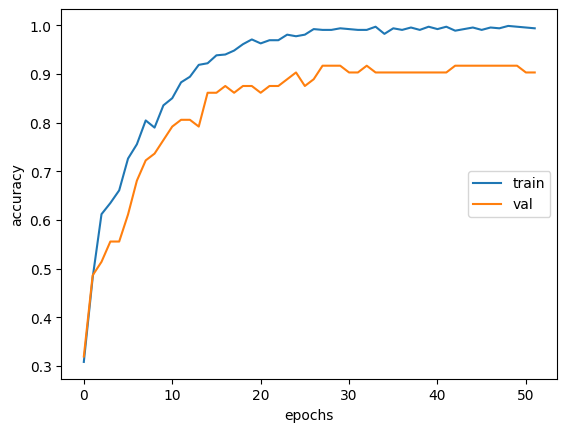

In [ ]:
plt.plot(history_res.history['acc'], label = 'train',)
plt.plot(history_res.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## DenseNet201

In [ ]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')


Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [ ]:
dense_model = DenseNet201(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in dense_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False
# Check if all layers except conv5 layers are not trainable
#for i, layer in enumerate(dense_model.layers):
#    print(i, layer.name, "-", layer.trainable)


In [ ]:
model = Sequential()
model.add(dense_model)
#model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
#model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 1920)           │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1920)           │         7,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         7,684 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,337,348 (69.95 MB)

 Trainable params: 6,990,084 (26.67 MB)

 Non-trainable params: 11,347,264 (43.29 MB)

In [ ]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
save_dir = '/content/'

In [ ]:
checkpointer = ModelCheckpoint(filepath=os.path.join(save_dir, 'chest_CT_SCAN-DenseNet201.keras'),
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [ ]:
history_dense = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 200,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - acc: 0.4271 - loss: 1.3177
Epoch 1: val_loss improved from inf to 1.33289, saving model to /content/chest_CT_SCAN-DenseNet201.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 296s 8s/step - acc: 0.4300 - loss: 1.3106 - val_acc: 0.2778 - val_loss: 1.3329
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - acc: 0.6732 - loss: 0.8361
Epoch 2: val_loss improved from 1.33289 to 1.21040, saving model to /content/chest_CT_SCAN-DenseNet201.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 744ms/step - acc: 0.6757 - loss: 0.8312 - val_acc: 0.3750 - val_loss: 1.2104
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - acc: 0.8166 - loss: 0.5723
Epoch 3: val_loss improved from 1.21040 to 1.11580, saving model to /content/chest_CT_SCAN-DenseNet201.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 759ms/step - acc: 0.8182 - loss: 0.5693 - val_acc: 0.4722 - val_loss: 1.1158
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - acc: 0.8851 - loss: 0.4543
Epoch 4: val_loss improved fro

In [ ]:
#model.save('/content/chest_CT_SCAN-DenseNet201.hdf5')
result = model.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - acc: 0.9060 - loss: 0.3808


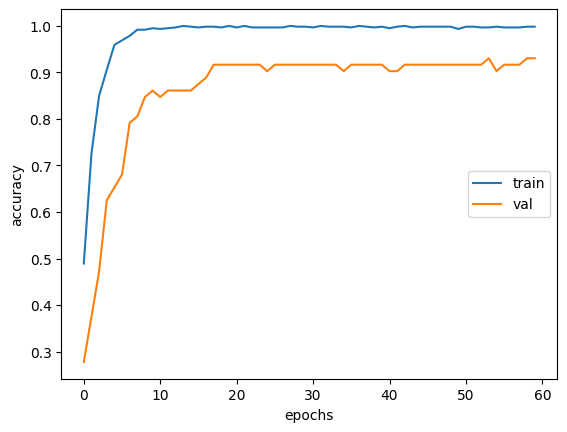

In [ ]:
plt.plot(history_dense.history['acc'], label = 'train',)
plt.plot(history_dense.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# Final Models are:
* **ResNet50** with **train 99.5  validation 89  test 91.7**
* **DenseNet201** with **train 100 validation 94.5 test 90**

In [ ]:
ResNet_Path = '/content/chest_CT_SCAN-ResNet50.keras'
DenseNet_Path = '/content/chest_CT_SCAN-DenseNet201.keras'

ResNet_model = tf.keras.models.load_model(ResNet_Path)
DenseNet_model = tf.keras.models.load_model(DenseNet_Path)

In [ ]:
path_adeno = '/content/drive/MyDrive/Data/test/adenocarcinoma'
path_large = '/content/drive/MyDrive/Data/test/large.cell.carcinoma'
path_normal = '/content/drive/MyDrive/Data/test/normal'
path_squamous = '/content/drive/MyDrive/Data/test/squamous.cell.carcinoma'

results_total = {'adeno':{},'large':{},'normal':{},'squamous':{}}
results_resnet = {'adeno':{},'large':{},'normal':{},'squamous':{}}
results_densenet = {'adeno':{},'large':{},'normal':{},'squamous':{}}

keys = ['adeno','large','normal','squamous']
for path ,key in zip([path_adeno,path_large,path_normal,path_squamous],keys):
    images = os.listdir(path)

    for image in images:

        my_image = load_img(path+'/'+image, target_size=(460, 460))
        my_image = img_to_array(my_image)
        my_image = my_image.reshape((1, 460, 460,3))
        my_image_dense = my_image.copy()
    # ResNet Only
        results_resnet[key][np.argmax(ResNet_model.predict(my_image))] = results_resnet.get(key).get(np.argmax(ResNet_model.predict(my_image)),0) +1
    # ResNet + DenseNet
        if np.max(ResNet_model.predict(my_image)) >=  np.max(DenseNet_model.predict(my_image)):

            results_total[key][np.argmax(ResNet_model.predict(my_image))] = results_total.get(key).get(np.argmax(ResNet_model.predict(my_image)),0) +1
        else:
            my_image = densenet.preprocess_input(my_image)
            results_total[key][np.argmax(DenseNet_model.predict(my_image))] = results_total[key].get(np.argmax(DenseNet_model.predict(my_image)),0) +1
    # DenseNet Only
        my_image_dense = densenet.preprocess_input(my_image_dense)
        results_densenet[key][np.argmax(DenseNet_model.predict(my_image_dense))] = results_densenet.get(key).get(np.argmax(DenseNet_model.predict(my_image_dense)),0) +1


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━

In [ ]:
print(results_total,'\n',results_resnet,'\n',results_densenet)

{'adeno': {np.int64(0): 93, np.int64(3): 10, np.int64(1): 17}, 'large': {np.int64(1): 50, np.int64(3): 1}, 'normal': {np.int64(2): 53, np.int64(1): 1}, 'squamous': {np.int64(3): 85, np.int64(1): 3, np.int64(0): 2}} 
 {'adeno': {np.int64(0): 98, np.int64(1): 12, np.int64(3): 10}, 'large': {np.int64(1): 38, np.int64(0): 9, np.int64(3): 4}, 'normal': {np.int64(2): 53, np.int64(1): 1}, 'squamous': {np.int64(3): 78, np.int64(0): 9, np.int64(1): 3}} 
 {'adeno': {np.int64(0): 90, np.int64(3): 6, np.int64(1): 24}, 'large': {np.int64(1): 50, np.int64(3): 1}, 'normal': {np.int64(2): 53, np.int64(1): 1}, 'squamous': {np.int64(3): 81, np.int64(1): 5, np.int64(2): 2, np.int64(0): 2}}


# From results we can see that using both models **argmax(ResNet + DenseNet)** is more accurate rather than using only one of them

In [ ]:
adeno_acc = 91 # conflicting with large
large_acc = 94
normal_acc = 98.5
squamous_acc = 92 #conflicting with adeno

acc = {'adeno_acc':91,'large_acc':94,'normal_acc':98.5,'squamous_acc':92}
df_acc = pd.DataFrame(acc.values(),index=acc.keys(),columns=['ACCURACY %'])
df_acc

,ACCURACY %
adeno_acc,91.0
large_acc,94.0
normal_acc,98.5
squamous_acc,92.0


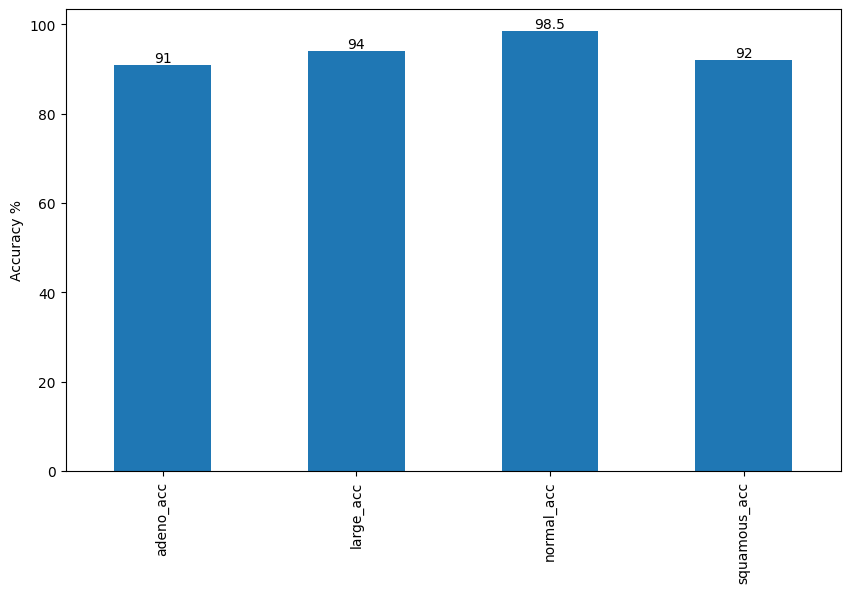

In [ ]:
ax = df_acc.plot(kind='bar', stacked= True, figsize= (10,6), ylabel= 'Accuracy %',legend = None)

for container in ax.containers:
    ax.bar_label(container)

In [ ]:
# import shutil

# # Specify the folder you want to zip
# folder_path = "/content/models"

# # Name for the output zip file (without .zip extension)
# zip_filename = "/content/models_prev"

# # Create the zip file
# shutil.make_archive(zip_filename, 'zip', folder_path)

# print(f"Folder zipped to: {zip_filename}.zip")


# from google.colab import files
# files.download(f"{zip_filename}.zip")


Folder zipped to: /content/models_prev.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>